In [2]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

from cataclop.ml import preprocessing
from cataclop.ml import exploration

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 500)

from cataclop.ml.pipeline import factories

In [3]:
program = factories.Program.factory('default', version='1.1')

In [4]:
program.predict(dataset_params = {
    'from': '2018-12-02',
    'to': '2018-12-31',
    'categories': ['PLAT']
}, model_params = {
    'kfolds': 3,
    'nan_flag': 100000
})

preparing model data
preparing stacked model data


In [5]:
def bet(df, features, categorical_features, targets, N=1, max_odds=20, break_on_bet=True, break_on_odds=False):

    races = df.sort_values('start_at').groupby('race_id')

    bets = []

    for (id, race) in races:

        candidate_bets = []

        nums = []

        for target in targets:

            r = race.sort_values(by=target, ascending=False)

            if len(r) <= N:
                break
                
            NN = N

            for n in range(NN):

                player = r.iloc[n]

                odds = player['final_odds_ref']

                if max_odds is not None and odds > max_odds:
                    if break_on_odds:
                        break
                    else:
                        continue

                #nth = (r['final_odds_ref']<odds).sum()+1
                
                if player[target] < 0:
                    break

                bet = np.clip(player[target]/100.0, 0, 10)
                
                bet = np.round(1+bet) * 1.5
                
                if bet <= 0:
                    break
                
                if n+1 < len(r) and r.iloc[n+1][target] == player[target]:
                    NN = NN+1
                    
                bet = 1

                profit = player['winner_dividend']/100.0 * bet - bet

                row = [id, player['start_at'], player['num'], player['position'], n, odds, player['final_odds'], target, player[target], r[target].std(), bet, profit]

                for nn in range(1,4):
                    if n+nn < len(r):
                        row.append(r.iloc[n+nn][target])
                    else:
                        row.append(np.nan)

                for f in features:
                    row.append(player[f])
                for f in categorical_features:
                    row.append(player[f])

                candidate_bets.append( row )

                nums.append(player['num'])

                if break_on_bet:
                    break

        #if len(candidate_bets) == 1:
        #    bets += candidate_bets
        bets += candidate_bets

    cols = ['id', 'date', 'num', 'pos', 'nb', 'odds_ref', 'odds_final', 'target', 'pred', 'pred_std', 'bet', 'profit']

    for nn in range(1,4):
        cols.append('next_pred_{}'.format(nn))

    cols = cols + features + categorical_features

    bets = pd.DataFrame(bets, columns=cols)
    bets['date'] = pd.to_datetime(bets['date'])

    bets = bets.set_index(bets['date'])

    bets = bets.sort_index()

    bets['bets'] = bets['bet'].cumsum()
    bets['stash'] = bets['profit'].cumsum()

    return bets



In [6]:
df = program.df
df['pred_rnd'] = np.random.rand(df.shape[0])
df['pred_sum'] = df[['pred_{}_1'.format(model['name']) for model in program.model.models ]].sum(axis=1)


for model in program.model.models:
    df['pred_minus_ref_{}'.format(model['name'])] = df['pred_{}_1'.format(model['name'])] - df['final_odds_ref']
    
for model in program.model.stacked_models:
    df['pred_minus_ref_stacked_{}'.format(model['name'])] = df['pred_stacked_{}_1'.format(model['name'])] - df['final_odds_ref']

bets = bet(df, program.model.features, program.model.categorical_features, 
    N=3, max_odds=30, break_on_bet=False, break_on_odds=False, 
    targets=['pred_rnd', 'final_odds_ref', 'pred_sum'] + ['pred_{}_1'.format(model['name']) for model in program.model.models] + ['pred_stacked_{}_1'.format(model['name']) for model in program.model.stacked_models] + ['pred_minus_ref_stacked_{}'.format(model['name']) for model in program.model.stacked_models] + ['pred_minus_ref_{}'.format(model['name']) for model in program.model.models]
   )
    

In [7]:
program.df.race_id.nunique()

406

In [8]:
def graph_bb(bb, f):
    results = []

    for s in bb[f].value_counts().index:
        results = []
        x = bb[ (bb[f] == s) & (bb['pred_std'] > 0) & (bb['pred'] > 0) ].copy()
        if len(x) == 0:
            continue
        #print("---\n{}\t{:+.2f}\t{:+.2f}\t{:+.2f}\n---".format(s, x['profit'].sum(), x['bet'].sum(), len(x)))

        fig, axs = plt.subplots(1,1)

        for t in x['target'].value_counts().index:
            bbb = x[(x['target'] == t)].copy()
            #bbb = bbb[ (bbb['pred']>bbb['pred'].quantile(0.85)) ].copy()


            results.append({
                'idx_1': s,
                'idx_2': t,
                'profit': bbb.profit.sum(),
                'bet': bbb.bet.sum(),
                'bets': bbb.bet.count(),
                'avg': bbb.profit.sum() / bbb.bet.sum()
            })

            '''
            bbb['stash'] = bbb['profit'].cumsum()
            bbb['cbet'] = bbb['bet'].cumsum()

            fig, axs = plt.subplots(1,1)
            bbb['stash'].plot(figsize=(6, 2))
            bbb['cbet'].plot(figsize=(6, 2))
            plt.show()
            '''

            #print("{:10s}: \t {:+.2f} \t {:+.0f} \t {:+.2f}".format(t, bbb.profit.sum(), bbb.profit.count(), bbb.profit.mean()) )

            bbb['stash'] = bbb['profit'].cumsum()
            bbb['cbet'] = bbb['bet'].cumsum()

            bbb['stash'].plot(figsize=(10, 2))
            bbb['cbet'].plot(figsize=(10, 2))

        results = pd.DataFrame(results)
        results = results.set_index(['idx_1', 'idx_2'])
        print(results.sort_values(by='avg', ascending=False))


        plt.show()    

    
    

In [9]:
#countries = list(bets['country'].value_counts()[0:10].index)
#sub_categories = list(bets['sub_category'].value_counts()[0:10].index)

#%store countries
#%store sub_categories

In [10]:
%store -r params
%store -r countries
%store -r sub_categories

In [11]:
from skopt.space import Real, Integer
from skopt.utils import use_named_args

target = 'final_odds_ref'

c_min = bets[(bets['target'] == target)]['pred'].min()
c_mean = bets[(bets['target'] == target)]['pred'].mean()
c_max = bets[(bets['target'] == target)]['pred'].max()

space = [
          Real(1, 10, name='min_odds'),
          Real(10, 30, name='max_odds'),
          Real(c_min, c_mean, name='min_pred'),
          Real(c_mean, c_max, name='max_pred'),
          Integer(5, 25, name='max_players')] + [
          Integer(0,1, name='country_{}'.format(country)) for country in countries] + [
          Integer(0,1, name='sub_category_{}'.format(sub_category)) for sub_category in sub_categories] + [
          Integer(0,1, name='nb_{}'.format(n)) for n in range(0,3)]
         
def x_to_params(x):
    params = {}
    
    params['min_odds'] = x[0]
    params['max_odds'] = x[1]
    params['max_pred'] = x[3]
    params['min_pred'] = x[2]
    params['max_players'] = x[4]
    
    for i, country in enumerate(countries):
        params['country_{}'.format(country)] = x[5+i]
        
    for i, sc in enumerate(sub_categories):
        params['sub_category_{}'.format(sc)] = x[5+len(countries)+i]
        
    for n in range(0,3):
        params['nb_{}'.format(n)] = x[5+len(countries)+len(sub_categories)+n]

    return params

@use_named_args(space)
def f(**params):
    return ff(params)
    
def ff(params, train=True):
    
    print(params)
    
    b = bets[ (bets['target']==target) & (bets['pred_std'] >= 0)]
    
    b = b[ (b['odds_ref'] > params['min_odds']) & (b['odds_ref'] < params['max_odds']) & (b['declared_player_count'] > 1) & (b['declared_player_count'] <= params['max_players']) ]
    
    b = b[(b['pred'] > params['min_pred']) & (b['pred'] < params['max_pred'])]
    
    for country in countries:
        if params['country_{}'.format(country)] == 0:
            b = b[ b['country'] != country ]
            
    for sub_category in sub_categories:
        if params['sub_category_{}'.format(sub_category)] == 0:
            b = b[ b['sub_category'] != sub_category ]
            
    for n in range(0,3):
        if params['nb_{}'.format(n)] == 0:
            b = b[ b['nb'] != n]
    
    p = b.profit.sum()
    bet = b.bet.sum()
    
    print("{:+.2f} {:+.2f}\n".format(p, bet))
        
    if bet == 0:
        return 0
    
    if not train:
        return b
    
    return - (p)
    
    

In [12]:
#from skopt import dummy_minimize, gp_minimize, gbrt_minimize

#res = gbrt_minimize(f, space, n_calls=100)

In [13]:
#print(res.x, res.fun)

In [14]:
#params = x_to_params(res.x)
#%store params

In [15]:
bb = ff(params, False)

{'min_odds': 6.646425335562837, 'max_odds': 17.704198469330386, 'max_pred': 0.23596574052830957, 'min_pred': 0.15756661921312204, 'max_players': 15, 'country_FRA': 0, 'country_DEU': 1, 'country_CHL': 0, 'country_GBR': 0, 'country_BEL': 1, 'country_CHN': 0, 'country_URY': 1, 'country_ZAF': 1, 'country_SGP': 1, 'country_ARE': 1, 'sub_category_COURSE_A_CONDITIONS': 0, 'sub_category_HANDICAP': 1, 'sub_category_HANDICAP_DIVISE': 1, 'sub_category_A_RECLAMER': 0, 'sub_category_HANDICAP_CATEGORIE_DIVISE': 1, 'sub_category_HANDICAP_DE_CATEGORIE': 0, 'sub_category_GROUPE_I': 0, 'sub_category_GROUPE_III': 0, 'sub_category_COURSE_A_CONDITION_QUALIF_HP': 1, 'sub_category_GROUPE_II': 1, 'nb_0': 0, 'nb_1': 1, 'nb_2': 0}
+0.00 +0.00



                             avg  bet  bets  profit
idx_1    idx_2                                     
HANDICAP pred_knn_10_1  0.511111   18    18     9.2


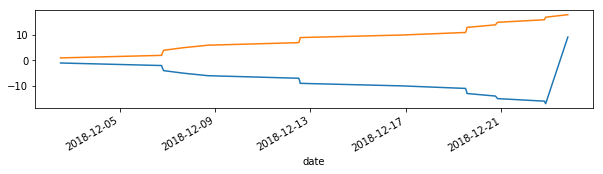

                                  avg  bet  bets  profit
idx_1           idx_2                                   
HANDICAP_DIVISE pred_knn_10_1  1.5125   16    16    24.2


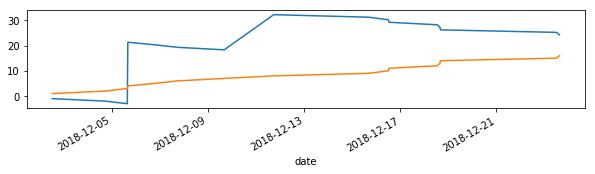

                                            avg  bet  bets  profit
idx_1                        idx_2                                
COURSE_A_CONDITION_QUALIF_HP pred_knn_10_1 -1.0    2     2    -2.0


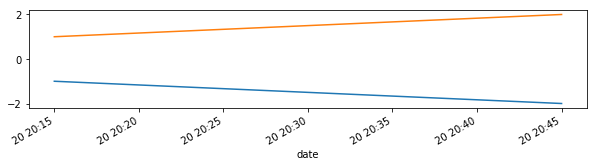

                          avg  bet  bets  profit
idx_1      idx_2                                
A_RECLAMER pred_knn_10_1 -1.0    2     2    -2.0


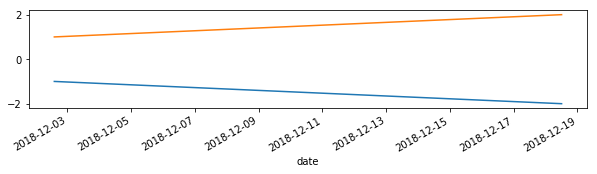

                        avg  bet  bets  profit
idx_1    idx_2                                
GROUPE_I pred_knn_10_1 -1.0    1     1    -1.0


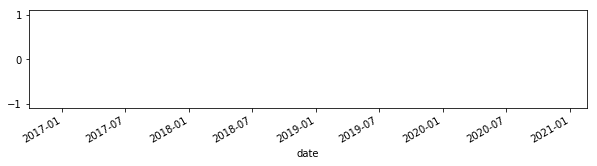

                                         avg  bet  bets  profit
idx_1                     idx_2                                
HANDICAP_CATEGORIE_DIVISE pred_knn_10_1 -1.0    1     1    -1.0


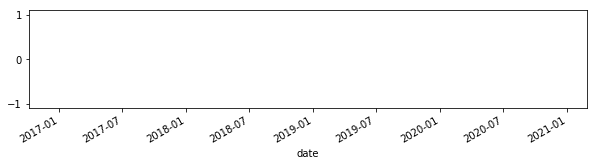

In [30]:
bb = bets[ (bets['sub_category']!='COURSE_A_CONDITIONS') & (bets['nb']==0) & (bets['target']=='pred_knn_10_1') & (bets['odds_ref']>10) & (bets['odds_ref']<20) & (bets['pred']>20)].copy()
#bb = bets[ (bets['country']=='FRA') & (bets['nb']==0) & (bets['odds_ref']>10) & (bets['odds_ref']<20) & (bets['pred']>0)].copy()
#bb = bb.groupby('id').filter(lambda r: r['num'].nunique() == 1)
#graph_bb( bets[(bets['target']=='pred_lasso_0.1_1') & (bets['nb']==0) & (bets['odds_ref']>5) & (bets['odds_ref']<20) & (bets['pred']>0.)], 'sub_category')
graph_bb(bb, 'sub_category')




In [17]:
bets[(bets['nb']<=0) & (bets['declared_player_count'] == 12) & (bets['target']=='pred_stacked_lasso_1')  & (bets['odds_ref']>0) & (bets['odds_ref']<30) & (bets['pred']>0.)]

,id,date,num,pos,nb,odds_ref,odds_final,target,pred,pred_std,bet,profit,next_pred_1,next_pred_2,next_pred_3,declared_player_count,handicap_distance,handicap_distance_amax,handicap_distance_amin,handicap_distance_mean,handicap_distance_r,handicap_distance_std,handicap_weight,handicap_weight_amax,handicap_weight_amin,handicap_weight_mean,handicap_weight_r,handicap_weight_std,hist_1_pos,hist_2_pos,hist_3_pos,hist_4_pos,hist_5_pos,hist_6_pos,odds_0,odds_1,odds_2,odds_3,odds_4,odds_5,odds_6,odds_7,odds_8,odds_9,placed_2_count,placed_2_count_amax,placed_2_count_amin,placed_2_count_mean,placed_2_count_r,placed_2_count_std,placed_3_count,placed_3_count_amax,placed_3_count_amin,placed_3_count_mean,placed_3_count_r,placed_3_count_std,placed_earnings,placed_earnings_amax,placed_earnings_amin,placed_earnings_mean,placed_earnings_r,placed_earnings_std,prev_year_earnings,prev_year_earnings_amax,prev_year_earnings_amin,prev_year_earnings_mean,prev_year_earnings_r,prev_year_earnings_std,prize,race_count,race_count_amax,race_count_amin,race_count_mean,race_count_r,race_count_std,victory_count,victory_count_amax,victory_count_amin,victory_count_mean,victory_count_r,victory_count_std,victory_earnings,victory_earnings_amax,victory_earnings_amin,victory_earnings_mean,victory_earnings_r,victory_earnings_std,category,sub_category,country,bets,stash
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-12-02 19:00:00,53031,2018-12-02 19:00:00,11,6.0,0,18.6,79.5,pred_stacked_lasso_1,28.986757,4.583535,1,-1.0,25.327310,22.223218,21.754947,12,0.0,0.0,0.0,0.0,100000.0,0.0,0.0,0.0,0.0,0.000000,100000.000000,0.000000,7.0,7.0,8.0,5.0,9.0,0.0,5.0,5.6,6.2,6.5,10.0,10.0,13.0,18.6,18.6,21.8,0,3,0,0.416667,-0.462790,0.900337,0,1,0,0.083333,-0.288675,0.288675,0.000000,11.990407,0.000000,3.791435,-0.676182,5.607125,0.000000,0.000000,0.00000,0.000000,100000.000000,0.000000,2457,20,20,0,4.500000,2.783882,5.567764,0,0,0,0.000000,100000.000000,0.000000,0.000000,11.990407,0.000000,3.791435,-0.676182,5.607125,PLAT,COURSE_A_CONDITIONS,URY,1250,-143.4
2018-12-05 12:00:00,53158,2018-12-05 12:00:00,9,11.0,0,3.8,21.6,pred_stacked_lasso_1,35.861246,7.359911,1,-1.0,27.268957,23.655010,21.210442,12,0.0,0.0,0.0,0.0,100000.0,0.0,15.0,19.0,10.0,15.583333,-0.220599,2.644319,0.0,4.0,6.0,7.0,7.0,0.0,3.8,4.7,5.8,6.3,9.9,16.6,20.5,23.3,29.1,29.1,0,7,0,1.416667,-0.734537,1.928652,0,7,0,2.500000,-0.984027,2.540580,13.019225,17.002760,13.019225,15.169019,-1.591863,1.350489,0.000000,16.547811,0.00000,11.659539,-1.652177,7.057078,75168,11,55,7,26.166667,-0.953406,15.907879,0,5,0,1.416667,-0.818948,1.729862,13.019225,17.553644,13.019225,15.624929,-1.571761,1.657824,PLAT,HANDICAP,AAA,2839,-839.1
2018-12-05 12:30:00,53159,2018-12-05 12:30:00,8,7.0,0,14.7,12.6,pred_stacked_lasso_1,32.462503,5.950973,1,-1.0,24.186817,23.938692,20.272527,12,0.0,0.0,0.0,0.0,100000.0,0.0,23.0,26.0,20.0,23.583333,-0.302457,1.928652,9.0,0.0,0.0,0.0,0.0,0.0,4.4,4.9,5.9,8.4,9.2,14.4,14.7,15.9,19.3,24.2,0,5,0,0.916667,-0.664755,1.378954,0,4,0,1.666667,-1.161051,1.435481,0.000000,16.852394,0.000000,14.046679,-3.086432,4.551106,0.000000,17.038709,0.00000,10.173013,-1.337664,7.605059,100224,1,35,1,16.333333,-1.582533,9.689107,0,4,0,0.916667,-0.664755,1.378954,0.000000,17.307554,0.000000,14.429392,-3.039682,4.747007,PLAT,HANDICAP,AAA,3085,-895.0
2018-12-05 13:10:00,53160,2018-12-05 13:10:00,9,7.0,0,6.8,12.2,pred_stacked_lasso_1,46.258413,11.582205,1,-1.0,44.295723,34.399520,28.172497,12,0.0,0.0,0.0,0.0,100000.0,0.0,23.0,27.0,19.0,23.666667,-0.232210,2.870962,0.0,8.0,0.0,0.0,0.0,0.0,2.9,3.2,6.8,10.5,18.6,19.5,24.4,24.4,30.0,43.4,0,6,0,2.250000,-1.074311,2.094365,0,10,0,1.416667,-0.492768,2.874918,0.000000,17.406725,0.000000,13.167974,-2.106236,6.251900,0.000000,17.092645,0.00000,10.432873,-1.347862,7.740315,120269,2,51,1,21.166667,-1.077641,17.785762,0,6,0,1.583333,-0.820954,1.928652,0.000000,17.827348,0.000000,13.653894,-2.093592,6.521755,PLAT,HANDICAP,AAA,3300,-1042.1
2018-12

In [18]:
df['placed_3_count'].describe()

count    5025.000000
mean        2.319403
std         3.096457
min         0.000000
25%         0.000000
50%         1.000000
75%         3.000000
max        32.000000
Name: placed_3_count, dtype: float64